In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orders=pd.read_csv("datasets/data_orders.csv")

In [3]:
orders['is_driver_assigned_key']=orders['is_driver_assigned_key'].map(lambda x : 'Assigned' if x==1 else 'Unassigned')
orders['order_status_key']=orders['order_status_key'].map(lambda x : 'cancelled by client' if x==4 else 'cancelled by system')

## (1)

In [5]:
failure_distribution=orders.groupby(['is_driver_assigned_key','order_status_key'])['order_gk'].count().reset_index(name="count")

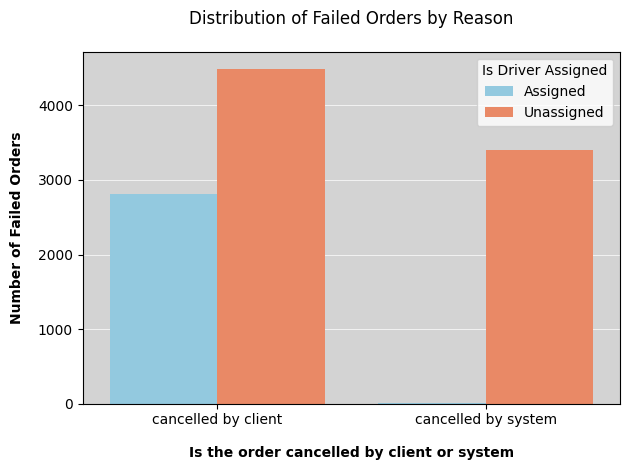

In [6]:
plt.axes().set_facecolor('lightgrey')
plt.grid(axis='y', color='white', linestyle='-', linewidth=0.5,zorder=1)

sns.barplot(x='order_status_key', y='count', hue='is_driver_assigned_key', data=failure_distribution,palette=['skyblue','coral'],zorder=2)

plt.xlabel('Is the order cancelled by client or system',labelpad=13.5,fontweight='bold')
plt.ylabel('Number of Failed Orders',labelpad=10,fontweight='bold')
plt.title('Distribution of Failed Orders by Reason',pad=20)
plt.legend(title='Is Driver Assigned')

plt.tight_layout()
plt.show()

Analysis:

1.Most of the orders are cancelled when the driver is not assigned regardless of the cancellation source.

2.More orders are cancelled by client whenever a driver is assigned or not.

3.If an order is cancelled by the system, we can almost make sure that it is cancelled by the system. The probable reason is that the system can not find relevant drivers in the vicinity of the client and hence cancel the order.

4.There is almost no cases of "A driver is assigned but the order is cancelled by the system." This may be caused by mistakes.

Tha category of "No driver is assigned and the order is cancelled by client" has the highest number of failed orders.

## (2)

In [7]:
orders['order_hour'] = pd.to_datetime(orders['order_datetime']).dt.hour
orderByHour=orders.groupby('order_hour')['order_gk'].count().reset_index(name="count")

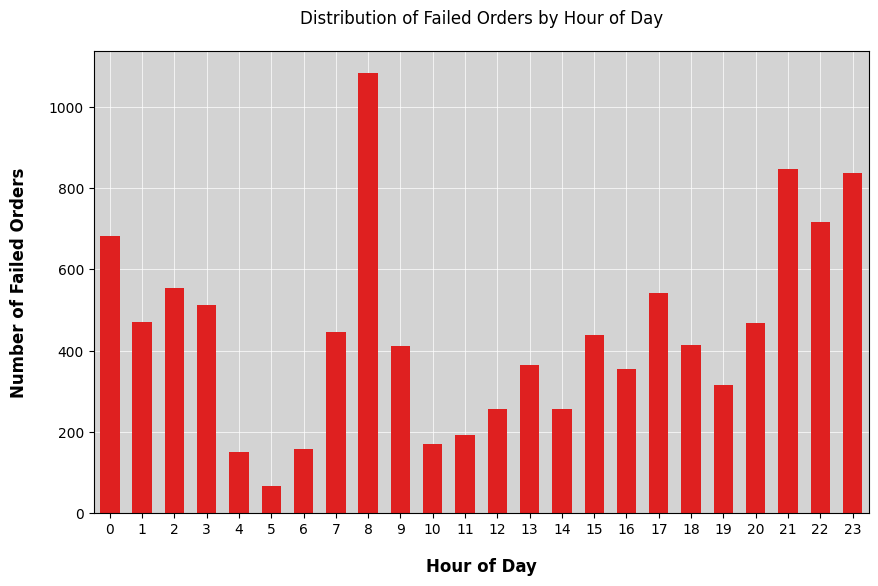

In [8]:
plt.figure(figsize=(10, 6))

plt.axes().set_facecolor('lightgrey')
plt.grid(axis='y', color='white', linestyle='-', linewidth=0.5,zorder=1)

sns.barplot(x="order_hour",y='count',data=orderByHour,width=0.6,color='red',zorder=2)

plt.grid(axis='x', which='major', color='white', linestyle='-', linewidth=0.5,zorder=1)

plt.title("Distribution of Failed Orders by Hour of Day",pad=20)
plt.xlabel("Hour of Day", fontsize=12,labelpad=15,fontweight='bold')
plt.ylabel("Number of Failed Orders", fontsize=12,labelpad=15,fontweight='bold')

plt.show()

From the plot of the overall distribution of failed orders by the hour, we can see the highest numbers of failed orders occur around 8:00, followed by 21:00 and 23:00

A possible reason is that the demand for taxis is very high or the number of working drivers is small during these periods.

In [9]:
orderByHourCat=orders.groupby(['is_driver_assigned_key','order_status_key','order_hour'])['order_gk'].count().reset_index(name="count")
orderByHourCat1=orderByHourCat[(orderByHourCat['is_driver_assigned_key']=='Assigned') & (orderByHourCat['order_status_key']=='cancelled by client')]
orderByHourCat2=orderByHourCat[(orderByHourCat['is_driver_assigned_key']=='Assigned') & (orderByHourCat['order_status_key']=='cancelled by system')]
orderByHourCat3=orderByHourCat[(orderByHourCat['is_driver_assigned_key']=='Unassigned') & (orderByHourCat['order_status_key']=='cancelled by client')]
orderByHourCat4=orderByHourCat[(orderByHourCat['is_driver_assigned_key']=='Unassigned') & (orderByHourCat['order_status_key']=='cancelled by system')]

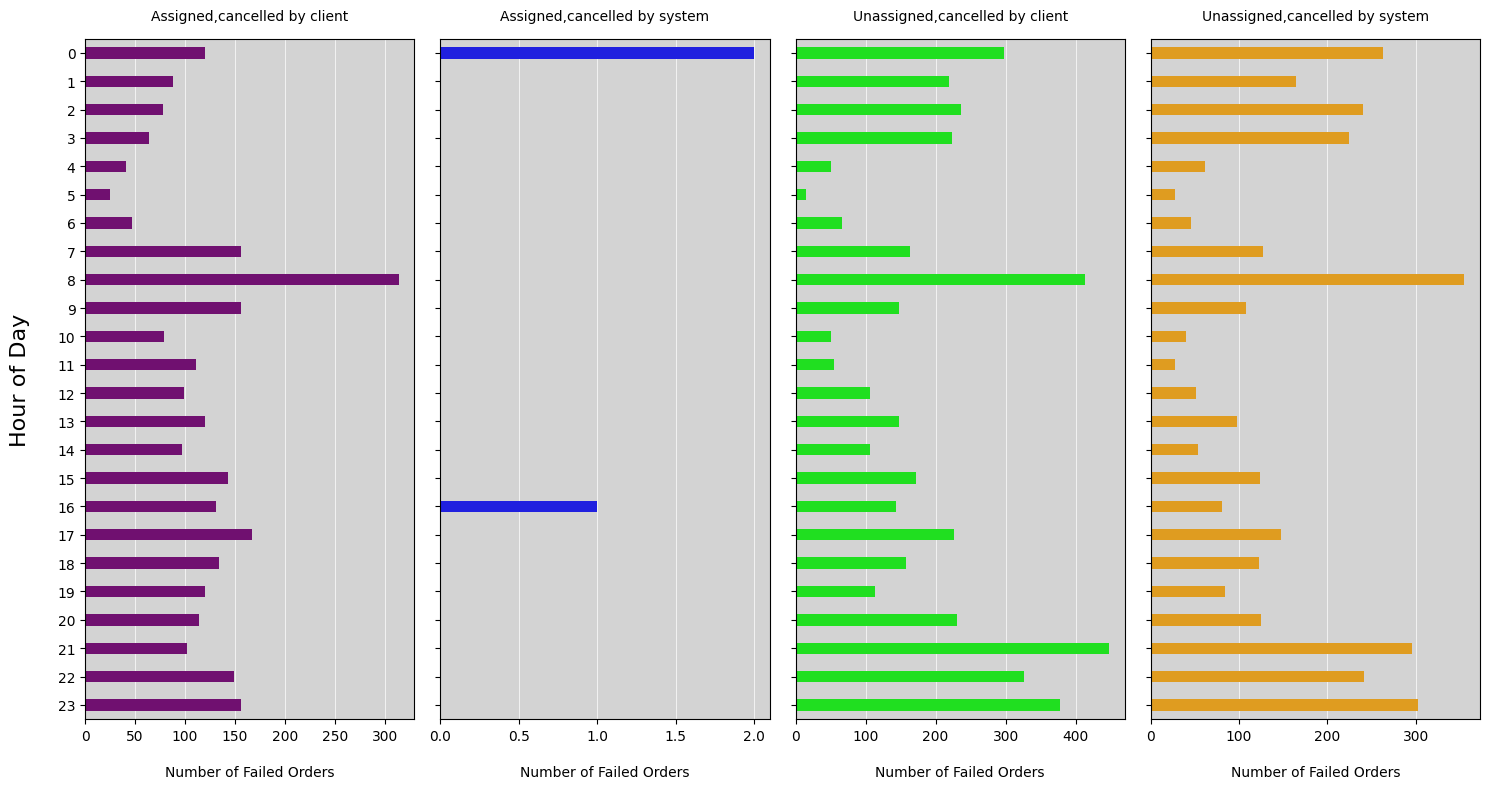

In [54]:
dataframe=[orderByHourCat1,orderByHourCat2,orderByHourCat3,orderByHourCat4]
colors=['purple','blue','lime','orange']
columns=[f"{df['is_driver_assigned_key'].iloc[0]},{df['order_status_key'].iloc[0]}" for df in dataframe]

flg,axs=plt.subplots(1,len(dataframe),figsize=(15,8),sharey=True)

for i,ax in enumerate(axs):
    Df=dataframe[i]
    ax.set_facecolor('lightgrey')
    ax.grid(axis='x', color='white', linestyle='-', linewidth=0.5,zorder=1)

    sns.barplot(x="count",y='order_hour',data=Df,width=0.4,color=colors[i],ax=ax,orient='y',zorder=2)
    ax.set_title(columns[i],fontsize=10,pad=13.5)
    ax.set_xlabel('Number of Failed Orders',labelpad=16)
    
axs[0].set_ylabel('Hour of Day',fontsize=16,labelpad=20)
plt.tight_layout()
plt.show()

Analysis: 

1.For the situation of "a driver is assigned but the order is cancelled by the system", there is only 3 cases so it is meaningless to analyse the data and it may be caused by some mistakes.

2.For the other 3 situations, the most failed orders all occur at around 8:00 which may be caused by morning peak. At the time, the high demand for taxis and the possible traffic congestion could lead to the failed orders

3.For the situations of " a driver is not assigned" regardless of the cancellation source (Plot 3 and Plot 4), there is also a peak in failed orders between 21:00 and 23:00 which is not observed in the category of "A driver is assigned and orders are cancelled by client" (Plot 1).
This may be due to a lack of driver supply during this time period and the orders can not be assigned and hence fail.

## (3)

In [13]:
orders['z_score']=(orders['cancellations_time_in_seconds']-orders['cancellations_time_in_seconds'].mean())/orders['cancellations_time_in_seconds'].std()
filter_df=orders[abs(orders['z_score'])<2]

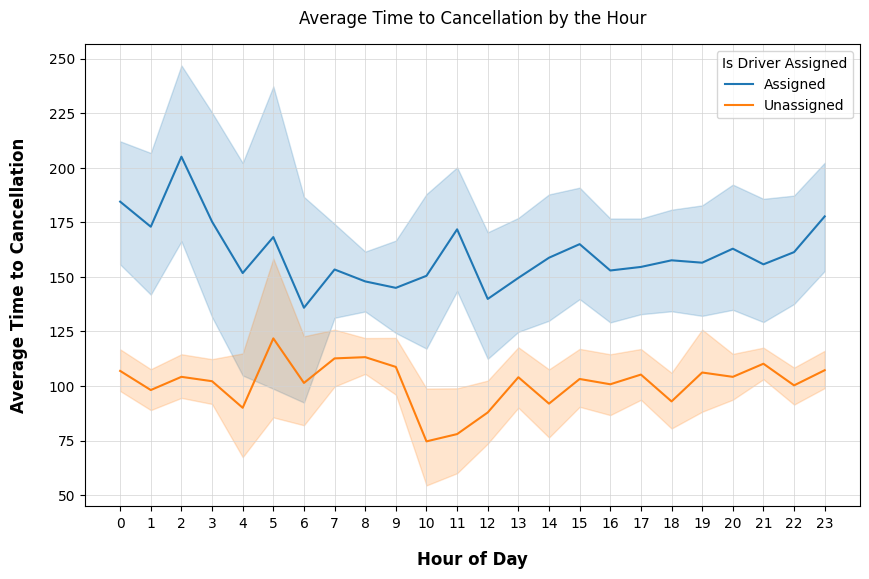

In [14]:
plt.figure(figsize=(10, 6))
plt.axes().set_facecolor('white')
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5,zorder=1)
plt.grid(axis='x', which='major', color='lightgrey', linestyle='-', linewidth=0.5,zorder=1)

sns.lineplot(x='order_hour', y='cancellations_time_in_seconds',hue='is_driver_assigned_key', data=filter_df,alpha=1)

plt.xticks(range(24))
plt.xlabel('Hour of Day',labelpad=15,fontweight='bold',fontsize=12)
plt.ylabel('Average Time to Cancellation',labelpad=15,fontweight='bold',fontsize=12)
plt.title('Average Time to Cancellation by the Hour',pad=15)
plt.legend(title='Is Driver Assigned')

plt.show()

From the plot, the average time to cancellation when a driver is assigned is longer during the whole day.

Since the columns of cancellation time is empty if the order is cancelled by the system, the chart actually only shows the data of orders which is cancelled by the clients. Therefore, we can conclude from the plot that the clients are more willing to wait when a driver is assigned for their orders.

In addition, the average time to cancellation in each hour of a day is nearly uniform which means the time of the order does not matter much on waiting time.

## (4)

In [15]:
AvgEtaByHour=orders.groupby('order_hour')['m_order_eta'].mean().reset_index(name="count")

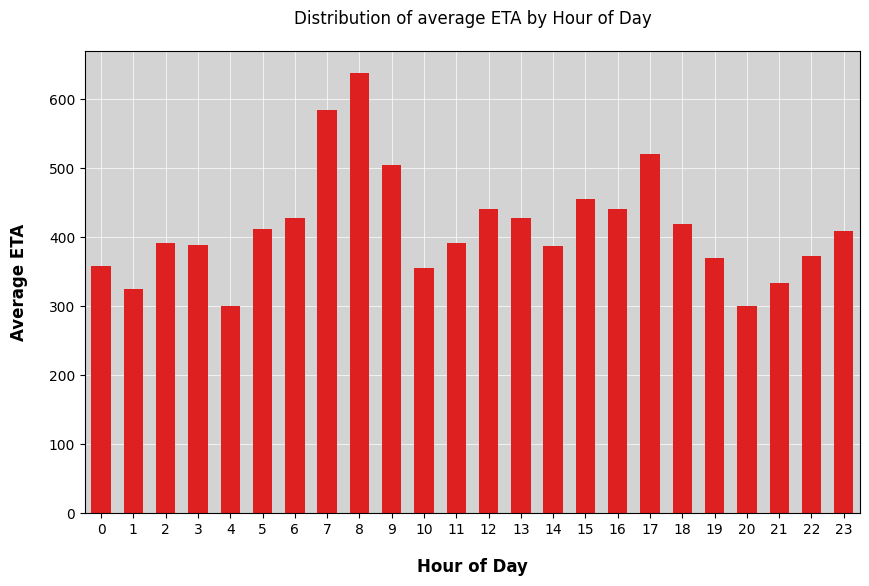

In [16]:
plt.figure(figsize=(10, 6))

plt.axes().set_facecolor('lightgrey')
plt.grid(axis='y', color='white', linestyle='-', linewidth=0.5,zorder=1)

sns.barplot(x="order_hour",y='count',data=AvgEtaByHour,width=0.6,color='red',zorder=2)

plt.grid(axis='x', which='major', color='white', linestyle='-', linewidth=0.5,zorder=1)

plt.title("Distribution of average ETA by Hour of Day",pad=20)
plt.xlabel("Hour of Day", fontsize=12,labelpad=15,fontweight='bold')
plt.ylabel("Average ETA", fontsize=12,labelpad=15,fontweight='bold')

plt.show()

Analysis:

1.The plot very closely matches the number of failed orders per hour which is shown in the plot of the distribution of failed orders by the hour. This means an order is more likely to fail as the average waiting time of the client increases.

2.There are two peaks in the plot: 8:00 and 17:00 which correspond to the morning peak and the evening peak. The traffic is quite congested during this time period so the average waiting time is longer.

## (5)

In [17]:
import h3
import folium

In [18]:
orders['hex_id'] = orders.apply(lambda x: h3.geo_to_h3(x['origin_latitude'], x['origin_longitude'], 8), axis=1)

In [19]:
hex_count=orders.groupby('hex_id')['order_gk'].count().reset_index(name="count").sort_values(by="count", ascending=False)
order_count=hex_count['count'].sum()

In [20]:
hex_count['sum_count']=hex_count['count'].cumsum()
top_hex_count=hex_count[hex_count['sum_count']<=order_count*0.8]
top_hexes_ids=top_hex_count['hex_id'].tolist()
hexes_ids=hex_count['hex_id'].tolist()
left_hexes_ids=[id for id in hexes_ids if id not in top_hexes_ids]

In [52]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","red"])

min_orders = hex_count['count'].min()
max_orders = hex_count['count'].max()
hex_count['color'] = hex_count['count'].apply(lambda x: cmap((x - min_orders) / (max_orders - min_orders)))

m = folium.Map(location=[51.45, -0.97], zoom_start=12)
for hex_id in top_hexes_ids:
    boundary = h3.h3_to_geo_boundary(hex_id)
    color = matplotlib.colors.to_hex(hex_count.loc[hex_count['hex_id'] == hex_id, 'color'].iloc[0])
    folium.Polygon(locations=boundary, fill=True, fill_color=color, color='black', weight=3, fill_opacity=0.5).add_to(m)
    
for hex_id in left_hexes_ids:
    boundary = h3.h3_to_geo_boundary(hex_id)
    color = matplotlib.colors.to_hex(hex_count.loc[hex_count['hex_id'] == hex_id, 'color'].iloc[0])
    folium.Polygon(locations=boundary, fill=True, color=color,weight=1,fill_opacity=0.5).add_to(m)
    
m.save('hex_map.html')

In [55]:
len(top_hexes_ids)

23

23 sizes 8 hexes contain 80% of all orders from the original data sets